In [38]:
# -*- coding: utf-8 -*-
"""GettingToKnowTheMelSpectrogram.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1q8lXmo2ZKJFiYf1Vjo3oNKCHZOKx8KHi

## Getting to Know the Mel Spectrogram


## This notebook was created to serve a blog post by the same name.
"""

# Commented out IPython magic to ensure Python compatibility.
# https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
import numpy as np
# %matplotlib inline

from IPython.display import Audio, display, Image

#function to find the fundamental pitch frequency counting zeroes
#From https://www.kaggle.com/asparago/simple-pitch-detector
def find_fundamental(signal, sampling_ratio):
  signal = signal
  #one should be careful in deciding if it is worth analysing the entire record or
  #just chunks of it, and excluding more noisy parts  
  #signal=signal[:len(signal)/2]
  rate = sampling_ratio #wf.getframerate()
  swidth = len(signal) # wf.getsampwidth()
  #first of all we remove the horizontal offset
  signal = signal - np.mean(signal)
  #now we calculate the autocorrelation of the signal against itself but inverted in time
  #and we throw away negative lags
  corr = sg.fftconvolve(signal, signal[::-1], mode='full')
  corr = corr[int(len(corr)/2):]
  diff = np.diff(corr)
  n = [i for i in range(0,len(diff)) if diff[i]>0][0]
  peak = np.argmax(corr[n:]) + n
  return rate/peak


/home/nacho/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


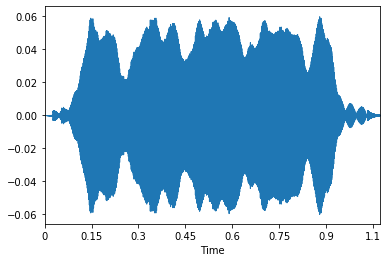

In [83]:
filename = "../audios/flute/flute_A4_1_forte_normal.mp3"
y, sr = librosa.load(filename)
# trim silent edges
audio_trimmed, _ = librosa.effects.trim(y)
Audio(data=audio_trimmed, rate=sr)

"""#### When we talk about sound, we generally talk about a sequence of vibrations in varying pressure strengths, so to visualize sound kinda means to visualize air waves."""

librosa.display.waveplot(audio_trimmed, sr=sr);

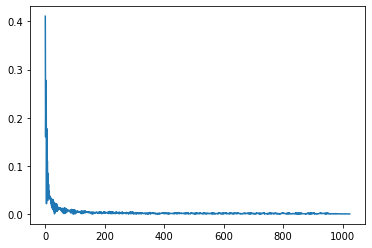

In [84]:
"""#### But this is a one dimensional representation of this complex and rich whale song. Another mathematical representation of sound is the Fourier Transform. Without going into too many details (watch this educational video for a comprehensible explanation), Fourier Transform is a function that gets a signal in the time domain as input, and outputs its decomposition into frequencies."""

# YouTubeVideo('spUNpyF58BY')

"""#### Let's take for example one short time window and see what we get from applying the Fourier Transform."""

n_fft = 2048
D = np.abs(librosa.stft(audio_trimmed[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D);
# plt.show()

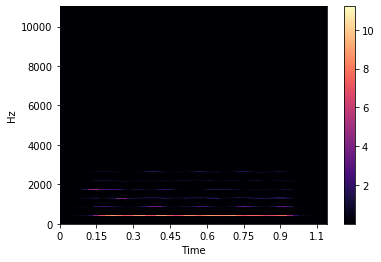

In [85]:
"""#### Now let's take the complete whale song, separate it to time windows, and apply the Fourier Transform on each time window."""

hop_length = 512
D = np.abs(librosa.stft(audio_trimmed, n_fft=n_fft, hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();
# plt.show()

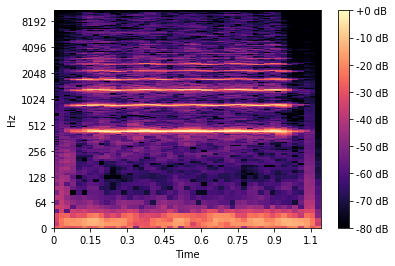

In [86]:
"""#### Wow can't see much here can we? It's because most sounds humans hear are concentrated in very small frequency and amplitude ranges.

#### Let's make another small adjustment - transform both the y-axis (frequency) to log scale, and the "color" axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.
"""

DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
# plt.show()

In [87]:
"""### The Mel Scale

#### Let's forget for a moment about all these lovely visualization and talk math. The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. This Mel Scale is constructed such that sounds of equal distance from each other on the Mel Scale, also "sound" to humans as they are equal in distance from one another.

#### In contrast to Hz scale, where the difference between 500 and 1000 Hz is obvious, whereas the difference between  7500 and 8000 Hz is barely noticeable.

#### Luckily, someone computed this non-linear transformation for us, and all we need to do to apply it is use the appropriate command from librosa.
"""

n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)


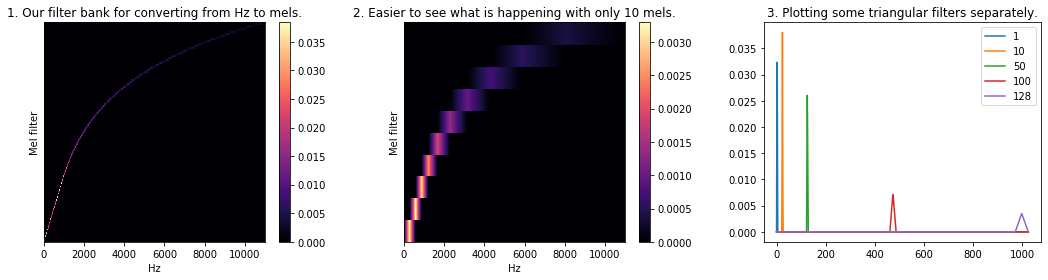

In [88]:

"""#### Yup. That's it.

#### But what does this give us?

#### It partitions the Hz scale into bins, and transforms each bin into a corresponding bin in the Mel Scale, using a overlapping triangular filters.
"""

plt.figure(figsize=(15, 4));

plt.subplot(1, 3, 1);
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('1. Our filter bank for converting from Hz to mels.');

plt.subplot(1, 3, 2);
mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('2. Easier to see what is happening with only 10 mels.');

plt.subplot(1, 3, 3);
idxs_to_plot = [0, 9, 49, 99, 127]
for i in idxs_to_plot:
    plt.plot(mel[i]);
plt.legend(labels=['{}'.format(i+1) for i in idxs_to_plot]);
plt.title('3. Plotting some triangular filters separately.');

plt.tight_layout();

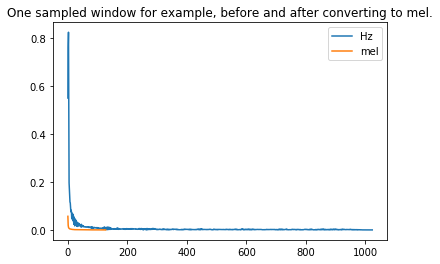

In [89]:
"""#### Now what does this give us?

#### Now we can take the amplitude of one time window, compute the dot product with mel to perform the transformation, and get a visualization of the sound in this new frequency scale.
"""

plt.plot(D[:, 1]);
plt.plot(mel.dot(D[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after converting to mel.');


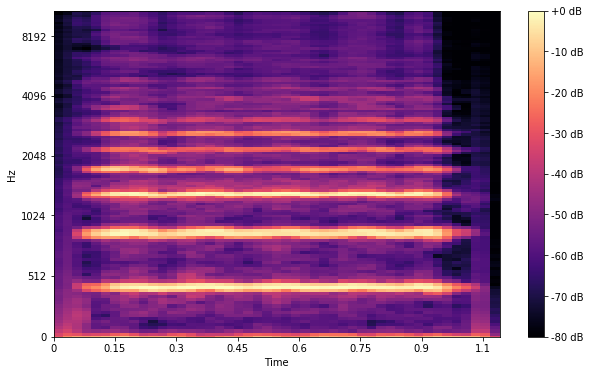

In [90]:
"""### The Mel Spectrogram

#### We know now what is a Spectrogram, and also what is the Mel Scale, so the Mel Spectrogram, is, rather surprisingly, a Spectrogram with the Mel Scale as its y axis.

#### And this is how you generate a Mel Spectrogram with one line of code, and display it nicely using just 3 more:
"""

S = librosa.feature.melspectrogram(audio_trimmed, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 6));
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [91]:
from scipy import signal as sg
# print(find_fundamental(S_DB, sr))

m = dict()
l = 0

for e in S_DB:
    for esa in e:
        if (esa > -70 and esa < -60):
            l = l+1
            if esa in m.keys():
                m[esa] = m[esa] + 1
            else:
                m[esa] = 1

print(l)                
                
# for k in m.keys():    
#     print(k)
#     print(m[k])
#     print("----")

print(S_DB)

916
[[-29.116928  -19.748798  -15.78132   ... -13.7145815 -19.376816
  -32.893345 ]
 [-32.892525  -28.65901   -30.140188  ... -27.349367  -28.671595
  -48.3869   ]
 [-37.645317  -34.36931   -39.5511    ... -38.398697  -38.327904
  -53.977592 ]
 ...
 [-76.16822   -72.352455  -70.14458   ... -79.74868   -80.
  -80.       ]
 [-80.        -76.302795  -68.920715  ... -80.        -80.
  -80.       ]
 [-80.        -80.        -80.        ... -80.        -80.
  -80.       ]]


In [92]:

"""### Recap

#### The Mel Spectrogram is the result of the following pipeline:
1. **Separate to windows**: Sample the input with windows of size n_fft=2048, making hops of size hop_length=512 each time to sample the next window. 

2. **Compute FFT** (Fast Fourier Transform) for each window to transform from time domain to frequency domain.

3. **Generate a Mel scale**: Take the entire frequency spectrum, and separate it into n_mels=128 evenly spaced frequencies. And what do we mean by evenly spaced? not by distance on the frequency dimension, but distance as it is heard by the human ear.

4. **Generate Spectrogram**: For each window, decompose the magnitude of the signal into its components, corresponding to the frequencies in the mel scale.
"""

# Sanity check that indeed we understood the underlying pipeline

S = librosa.feature.melspectrogram(audio_trimmed, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

fft_windows = librosa.stft(audio_trimmed, n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(fft_windows)**2
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

assert (mel.dot(magnitude) == S).all()

Image(url="https://i.imgflip.com/37ohpy.jpg")

plt.show()